# Plotting validation periods

---

## 1. Define the experiment parameters

#### Import libs

In [1]:
import numpy as np
import pickle, math
import pandas as pd
import multiprocessing

In [2]:
from lib.mobilitysim import MobilitySimulator
from lib.parallel import launch_parallel_simulations
from lib.distributions import CovidDistributions
from lib.data import collect_data_from_df
from lib.measures import (
    MeasureList, Interval,
    BetaMultiplierMeasureByType,
    SocialDistancingForAllMeasure, 
    SocialDistancingForPositiveMeasure,
    SocialDistancingForPositiveMeasureHousehold)

from lib.inference import gen_initial_seeds, downsample_cases
from lib.plot import Plotter

from lib.experiment import run_experiment, save_summary, load_summary, get_calibrated_params

from lib.calibration_settings import (
    command_line_area_codes, 
    settings_lockdown_dates,
    settings_model_param_bounds,
    calibration_setting_paths,
    calibration_setting_paths_full,
    calibration_states)
import matplotlib.pyplot as plt

In [3]:
calibration_period_only = False
full_scale = True
p_stay_home = 1.0 # TBD
dry_run = True
plot = True

#
######
#
random_repeats = 80 
c = 0
np.random.seed(c)
num_workers = multiprocessing.cpu_count()
TO_HOURS = 24.0

In [4]:
def standard_testing(max_time, cases):
    daily_increase = cases.sum(axis=1)[1:] - cases.sum(axis=1)[:-1]
    standard_testing_params = {
        'testing_t_window'    : [0.0, max_time], # in hours
        'testing_frequency'   : 1 * TO_HOURS,     # in hours
        'test_reporting_lag'  : 2 * TO_HOURS,     # in hours (actual and self-report delay)
        'tests_per_batch'     : int(daily_increase.max()), # test capacity based on empirical positive tests
        'test_fpr'            : 0.0, # test false positive rate
        'test_fnr'            : 0.0, # test false negative rate
        'test_smart_delta'    : 3 * TO_HOURS, # in hours
        'test_smart_duration' : 7 * TO_HOURS, # in hours
        'test_smart_action'   : 'isolate', 
        'test_smart_num_contacts'   : 10, 
        'test_targets'        : 'isym',
        'test_queue_policy'   : 'fifo',
        'smart_tracing'       : None, 
    }
    return standard_testing_params

def params_to_strg(d):
    l = [
        f"{d['betas']['education']:8.4f}",
        f"{d['betas']['social']:8.4f}",
        f"{d['betas']['bus_stop']:8.4f}",
        f"{d['betas']['office']:8.4f}",
        f"{d['betas']['supermarket']:8.4f}",
        f"{d['beta_household']:8.4f}",
    ]
    return ','.join(l)

headerstr = ' educat | social | bus_st | office | superm | househ '

#### Simulate for each town

In [5]:
if full_scale:
    setting_paths = calibration_setting_paths_full
else:
    setting_paths = calibration_setting_paths

In [6]:
for country in ['GER', 'CH']:
    for area in setting_paths[country].keys():
        
        # start simulation when calibration started       
        mob_settings = setting_paths[country][area][0]
        start_date_calibration = setting_paths[country][area][1]
        end_date_calibration = setting_paths[country][area][2]

        # lockdown dates
        start_date_lockdown = settings_lockdown_dates[country]['start']
        end_date_lockdown = settings_lockdown_dates[country]['end']      

        # set time frame
        if calibration_period_only:
            start_date = start_date_calibration
            end_date = end_date_calibration
        else:
            start_date = start_date_calibration
            end_date = end_date_lockdown

        sim_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
        max_time = TO_HOURS * sim_days # in hours

        # load mobility file
        with open(mob_settings, 'rb') as fp:
            obj = pickle.load(fp)
        mob = MobilitySimulator(**obj)

        # case data + scaling
        unscaled_area_cases = collect_data_from_df(country=country, area=area, datatype='new',
            start_date_string=start_date, end_date_string=end_date)
        
        sim_cases, unscaled_sim_cases = downsample_cases(unscaled_area_cases, mob)
        
        # distributions
        distributions = CovidDistributions(country=country)

        # seeds
        initial_seeds = gen_initial_seeds(
            unscaled_sim_cases, 
            downsampling=mob.downsample,
            day=0)

        # calibrated parameters
        calibrated_params = get_calibrated_params(country, area)

        print(country, area, f'{mob.downsample}x', ' Days: ', sim_days,'  Start: ', start_date, '  End: ', end_date, )
        print('Start cases: Scaled : ', sim_cases[0].sum(), sim_cases[0], 'Unscaled : ' , unscaled_sim_cases[0].sum(), unscaled_sim_cases[0])
        print('End cases:   Scaled : ',  sim_cases[-1].sum(), sim_cases[-1], 'Unscaled : ' , unscaled_sim_cases[-1].sum(), unscaled_sim_cases[-1])
        print('Scaled seeds:  ', initial_seeds)
        print('Unscaled seeds:',  gen_initial_seeds(
            unscaled_sim_cases, 
            downsampling=1,
            day=0))
        
        print(headerstr)
        print(params_to_strg(calibrated_params))

        # run
        measure_list =  [
            SocialDistancingForPositiveMeasure(
                t_window=Interval(0.0, max_time), p_stay_home=1.0),

            SocialDistancingForPositiveMeasureHousehold(
                t_window=Interval(0.0, max_time), p_isolate=1.0)
        ]

        if not calibration_period_only:
            days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days
            measure_list += [
                BetaMultiplierMeasureByType(
                    t_window=Interval(days_until_lockdown * TO_HOURS, max_time * TO_HOURS), 
                    beta_multiplier={ 
                        'education': 0.0, 
                        'social': 0.0, 
                        'bus_stop': 1.0, 
                        'office': 0.0, 
                        'supermarket': 1.0
                    }),
                SocialDistancingForAllMeasure(
                    t_window=Interval(days_until_lockdown * TO_HOURS, max_time * TO_HOURS), 
                    p_stay_home=p_stay_home)
            ]

        measure_list = MeasureList(measure_list)

        # testing
        testing_params = standard_testing(max_time, sim_cases)
        print('Test capacity: Scaled: ', testing_params['tests_per_batch'], ' Unscaled: ', standard_testing(max_time, unscaled_sim_cases)['tests_per_batch'])
        print()
        if not dry_run:
            # run simulations
            summary = launch_parallel_simulations(
                mob_settings=mob_settings, 
                distributions=distributions, 
                random_repeats=random_repeats, 
                cpu_count=num_workers, 
                params=calibrated_params, 
                initial_seeds=initial_seeds, 
                testing_params=testing_params, 
                measure_list=measure_list, 
                max_time=max_time, 
                num_people=mob.num_people, 
                num_sites=mob.num_sites, 
                site_loc=mob.site_loc, 
                home_loc=mob.home_loc,
                lazy_contacts=True,
                verbose=False)

            appdx = 'full' if full_scale else 'downscaled'
            if calibration_period_only:
                save_summary(summary, 'summary-calib--{}-{}--{}.pk'.format(country, area, appdx))
            else:
                save_summary(summary, 'summary-calib_lockdown--{}-{}--{}-{}.pk'.format(
                    country, area, appdx, p_stay_home))



GER TU 1x  Days:  52   Start:  2020-03-12   End:  2020-05-03
Start cases: Scaled :  9.0 [0. 1. 2. 5. 1. 0.] Unscaled :  9.0 [0. 1. 2. 5. 1. 0.]
End cases:   Scaled :  491.0 [  4.   6. 128. 196.  96.  61.] Unscaled :  491.0 [  4.   6. 128. 196.  96.  61.]
Scaled seeds:   {'expo': 30, 'isym_posi': 9, 'iasy': 6}
Unscaled seeds: {'expo': 30, 'isym_posi': 9, 'iasy': 6}
 educat | social | bus_st | office | superm | househ 
  0.0000,  1.3259,  1.5504,  2.4694,  1.4561,  0.8040
Test capacity: Scaled:  72  Unscaled:  72

GER KL 1x  Days:  49   Start:  2020-03-15   End:  2020-05-03
Start cases: Scaled :  8.0 [0. 0. 4. 4. 0. 0.] Unscaled :  8.0 [0. 0. 4. 4. 0. 0.]
End cases:   Scaled :  122.0 [ 1.  3. 63. 33. 14.  8.] Unscaled :  122.0 [ 1.  3. 63. 33. 14.  8.]
Scaled seeds:   {'expo': 27, 'isym_posi': 8, 'iasy': 5}
Unscaled seeds: {'expo': 27, 'isym_posi': 8, 'iasy': 5}
 educat | social | bus_st | office | superm | househ 
  0.5892,  1.2803,  1.4708,  2.6331,  2.1763,  0.8541
Test capacity: Scal

---

GER TU
GER TU  file not found.
GER KL
summary-calib_lockdown--GER-KL--full-1.0.pk
GER RH
GER RH  file not found.
GER TR
GER TR  file not found.
CH VD
CH VD  file not found.
CH BE
CH BE  file not found.
CH TI
CH TI  file not found.
CH JU
summary-calib_lockdown--CH-JU--full-1.0.pk


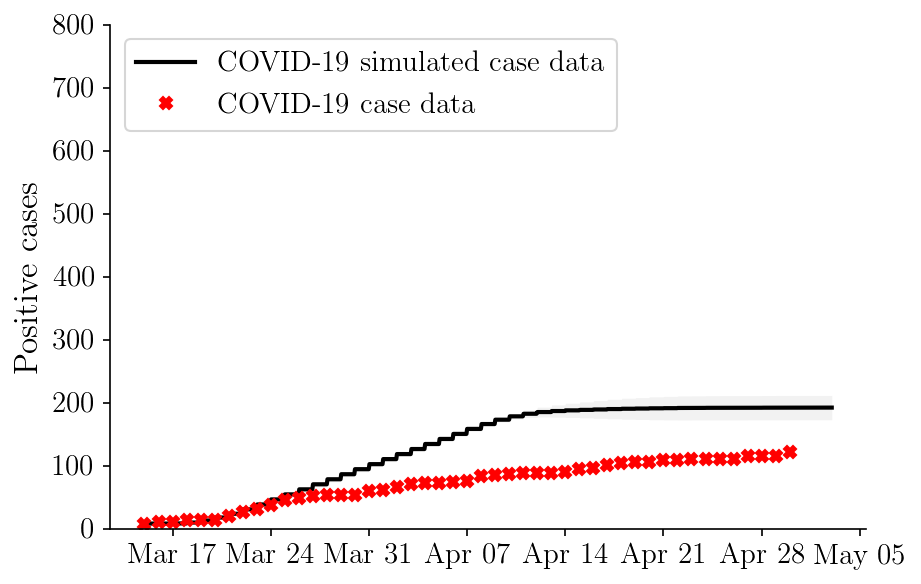

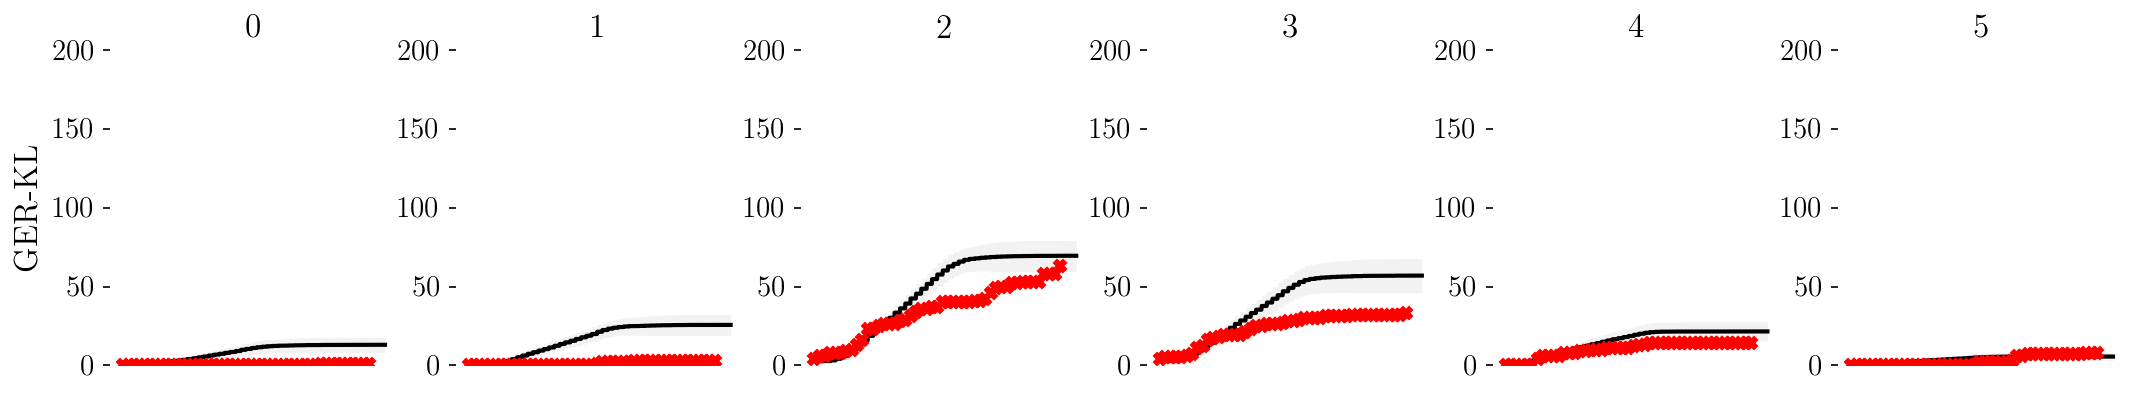

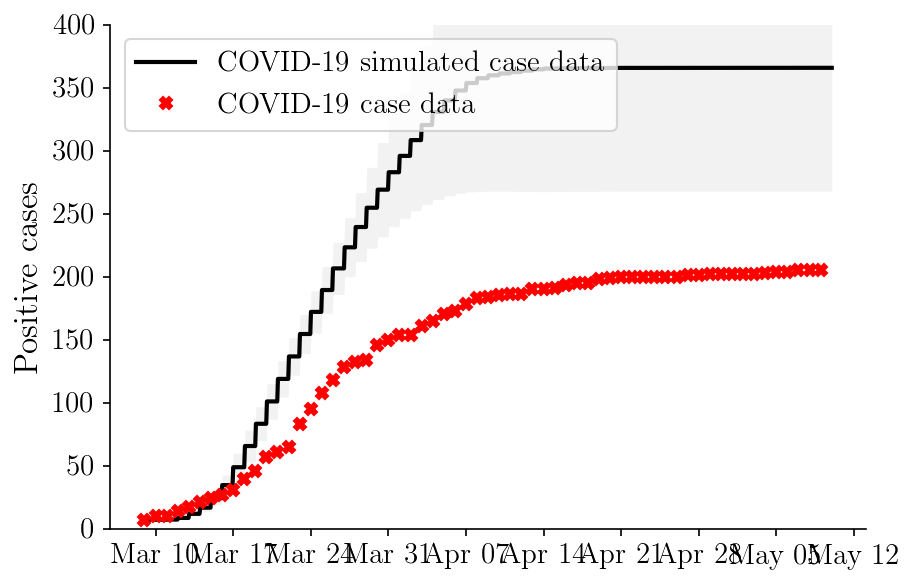

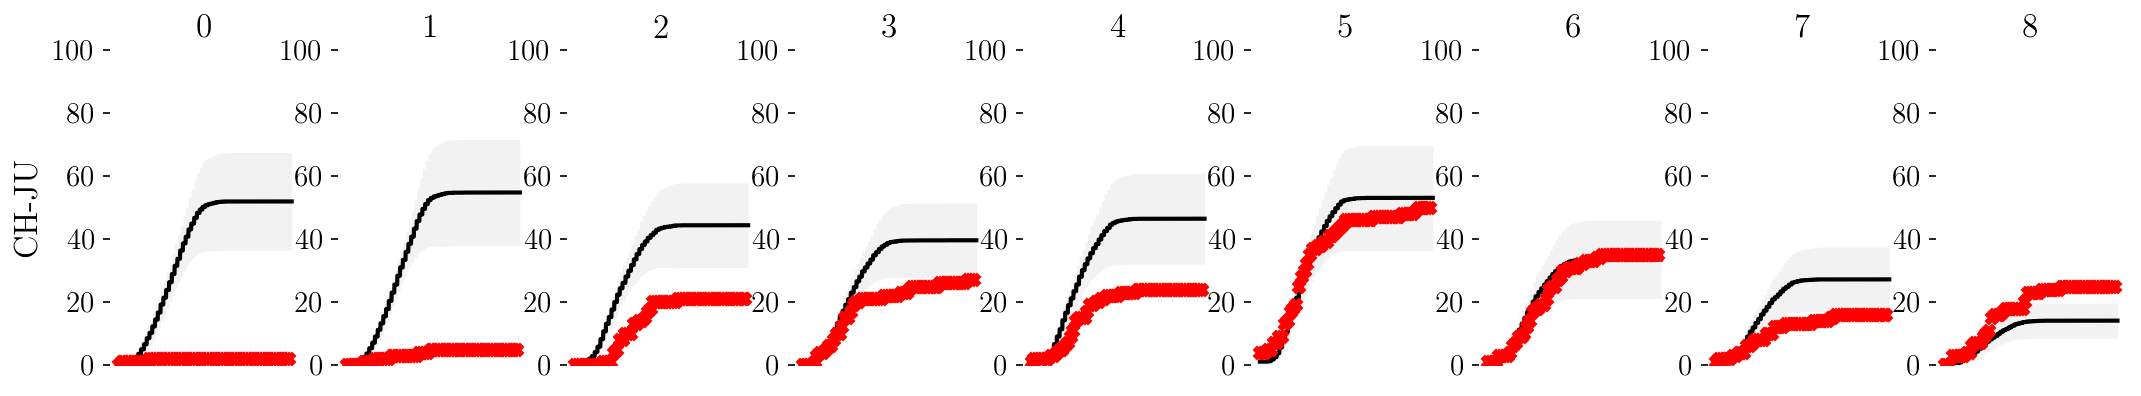

In [7]:
ymax = {
    'GER' : {
        'TU' : 500,
        'KL' : 200,
        'RH' : 300,
        'TR' : 500,
    },
    'CH' : {
        'VD' : 500,
        'BE' : 150,
        'TI' : 100,
        'JU' : 100,
    }
}

if plot:
    for country in ['GER', 'CH']:
        for area in setting_paths[country].keys():
            
            try:
#                 if area not in ['BE']:
#                     continue
                    
                print(country, area)

                # start simulation when calibration started       
                mob_settings = setting_paths[country][area][0]
                start_date_calibration = setting_paths[country][area][1]
                end_date_calibration = setting_paths[country][area][2]

                # lockdown dates
                start_date_lockdown = settings_lockdown_dates[country]['start']
                end_date_lockdown = settings_lockdown_dates[country]['end']      

                # set time frame
                if calibration_period_only:
                    start_date = start_date_calibration
                    end_date = end_date_calibration
                else:
                    start_date = start_date_calibration
                    end_date = end_date_lockdown

                sim_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
                max_time = TO_HOURS * sim_days # in hours

                # load mobility file
                with open(mob_settings, 'rb') as fp:
                    obj = pickle.load(fp)
                mob = MobilitySimulator(**obj)

                # case data + scaling
                unscaled_area_cases = collect_data_from_df(country=country, area=area, datatype='new',
                    start_date_string=start_date, end_date_string=end_date)

                sim_cases, unscaled_sim_cases = downsample_cases(unscaled_area_cases, mob)

                appdx = 'full' if full_scale else 'downscaled'
                if calibration_period_only:
                    loadstr = 'summary-calib--{}-{}--{}.pk'.format(country, area, appdx)
                    summary = load_summary(loadstr)
                    print(loadstr)
                else:
                    loadstr = 'summary-calib_lockdown--{}-{}--{}-{}.pk'.format(
                        country, area, appdx, p_stay_home)
                    summary = load_summary(loadstr)
                    print(loadstr)
                
                # ymax depending on full scale vs downsampling
                ym = (4 if full_scale else 1) * ymax[country][area] / (mob.downsample) 

                plotter = Plotter()
                plotter.plot_positives_vs_target(
                    summary, sim_cases.sum(axis=1), 
                    title='Calibration period', 
                    filename='calibration-{}-{}-{}-{}'.format('only-calib' if calibration_period_only else 'full',country, area, appdx),
                    figsize=(6, 4),
                    start_date=start_date,
                    errorevery=1, acc=1000, 
                    ymax=int(ym),
                )

                plotter.plot_age_group_positives_vs_target(
                    summary, sim_cases, 
                    ytitle=f'{country}-{area}',
                    filename='calibration-{}-{}-{}-age-{}'.format('only-calib' if calibration_period_only else 'full', country, area, appdx),
                    figsize=(16, 2.5),
                    start_date=start_date,
                    errorevery=1, acc=1000, 
                    ymax=int(ym / 4),
                )

            except FileNotFoundError:
                print(country, area, ' file not found.')
        